In [1]:
import numpy as np
import time
import torch
import random
import sys
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn, optim, autograd
from scipy.integrate import odeint

from google.colab import drive
drive.mount("/content/drive")

main_path = "/content/drive/My Drive/Workspace/Fourier_PINN/" # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)

from utils import draw_two_dimension, MultiSubplotDraw

Mounted at /content/drive


In [97]:
class Parameters:
    beta = 10
    rho = 1e-6
    gamma = 1
    n = 3

class TrainArgs:
    iteration = 1000000
    epoch_step = 10
    test_step = 100
    initial_lr = 0.001
    main_path = "/content/drive/My Drive/Workspace/Fourier_PINN/"


class Config:
    def __init__(self):
        self.model_name = "Repressilator_Fourier"
        self.curve_names = ["m_lacl", "m_tetR", "m_cl", "p_cl", "p_lacl", "p_tetR"]
        self.params = Parameters
        self.args = TrainArgs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 0

        self.T = 20
        self.T_unit = 1e-2
        self.T_N = int(self.T / self.T_unit)

        self.prob_dim = 6
        self.y0 = np.asarray([9.0983668,0.90143886,0.15871683,7.2439572,2.85342356,0.15983291])  # np.asarray([1, 1.1, 1.2, 0, 0, 0])
        self.t = np.asarray([i * self.T_unit for i in range(self.T_N)])
        self.t_torch = torch.tensor(self.t, dtype=torch.float32).to(self.device)
        self.x = torch.tensor(np.asarray([[[i * self.T_unit] * self.prob_dim for i in range(self.T_N)]]), dtype=torch.float32).to(self.device)
        # print(self.x.shape)
        self.truth = odeint(self.pend, self.y0, self.t)

        self.modes = 16#64  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.width = 16
        self.fc_map_dim = 128
    
    def pend(self, y, t):
        k = self.params
        dydt = np.asarray([
            k.beta * ( k.rho + 1 / (1 + y[5] ** k.n) ) - y[0],
            k.beta * ( k.rho + 1 / (1 + y[3] ** k.n) ) - y[1],
            k.beta * ( k.rho + 1 / (1 + y[4] ** k.n) ) - y[2],
            k.gamma * ( y[0] - y[3] ),
            k.gamma * ( y[1] - y[4] ),
            k.gamma * ( y[2] - y[5] )
        ])
        return dydt


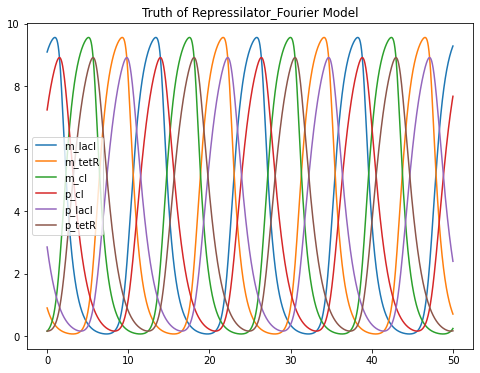

In [15]:
config = Config()
truth_plot = np.swapaxes(config.truth, 0, 1)
plt.figure(figsize=(8, 6))
for i, line in enumerate(truth_plot):
    plt.plot(config.t, truth_plot[i], label=config.curve_names[i])
plt.legend()
plt.title("Truth of {} Model".format(config.model_name))
plt.show()
plt.close()

In [86]:
for i in range(6):
  print(np.var(config.truth[:, i]))

13.174711808440573
10.961480157009976
12.883215820608159
10.336504788479655
7.896880696239234
10.298169190099827


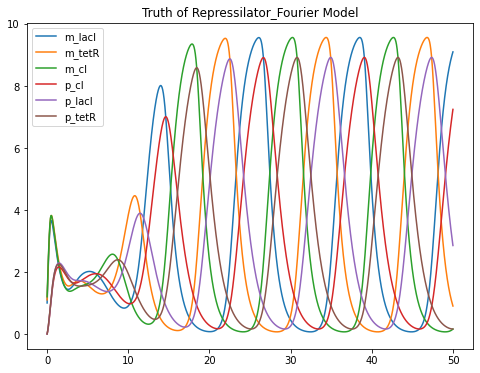

In [3]:
config = Config()
truth_plot = np.swapaxes(config.truth, 0, 1)
plt.figure(figsize=(8, 6))
for i, line in enumerate(truth_plot):
    plt.plot(config.t, truth_plot[i], label=config.curve_names[i])
plt.legend()
plt.title("Truth of {} Model".format(config.model_name))
plt.show()
plt.close()

In [12]:
print(config.truth[-1, :])

[9.0983668  0.90143886 0.15871683 7.2439572  2.85342356 0.15983291]


In [93]:
class SpectralConv1d(nn.Module):
    def __init__(self, config):
        super(SpectralConv1d, self).__init__()
        self.config = config
        self.in_channels = self.config.width
        self.out_channels = self.config.width
        self.scale = 1 / (self.in_channels * self.out_channels)
        self.weights = nn.Parameter(self.scale * torch.rand(self.in_channels, self.out_channels, self.config.modes, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, dtype=torch.cfloat).to(self.config.device) 
        out_ft[:, :, :self.config.modes] = self.compl_mul1d(x_ft[:, :, :self.config.modes], self.weights)
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

def penalty_func(x):
    return 1 * (- torch.tanh((x - 1.5)) + 1)# return 1 * (- torch.tanh((x - 2.5)) + 1)

class FourierModel(nn.Module):
    def __init__(self, config):
        super(FourierModel, self).__init__()
        self.time_string = time.strftime("%Y%m%d_%H%M%S", time.localtime(time.time()))
        self.config = config
        self.setup_seed(self.config.seed)
        
        self.fc0 = nn.Linear(self.config.prob_dim, self.config.width)  # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.config)
        self.conv1 = SpectralConv1d(self.config)
        self.conv2 = SpectralConv1d(self.config)
        self.conv3 = SpectralConv1d(self.config)
        self.w0 = nn.Conv1d(self.config.width, self.config.width, 1)
        self.w1 = nn.Conv1d(self.config.width, self.config.width, 1)
        self.w2 = nn.Conv1d(self.config.width, self.config.width, 1)
        self.w3 = nn.Conv1d(self.config.width, self.config.width, 1)

        self.fc1 = nn.Linear(self.config.width, self.config.fc_map_dim)
        self.fc2 = nn.Linear(self.config.fc_map_dim, self.config.prob_dim)

        self.criterion = torch.nn.MSELoss("sum").to(self.config.device)

        self.y_tmp = None
        self.epoch_tmp = None
        self.loss_record_tmp = None

        self.figure_save_path_folder = "{0}/figure/{1}_{2}/".format(self.config.args.main_path, self.config.model_name, self.time_string)
        if not os.path.exists(self.figure_save_path_folder):
            os.makedirs(self.figure_save_path_folder)
        self.default_colors = ["red", "blue", "green", "pink", "cyan", "lime", "pink", "indigo", "brown", "grey", "indigo", "olive"]

        print("using {}".format(str(self.config.device)))
        print("iteration = {}".format(self.config.args.iteration))
        print("epoch_step = {}".format(self.config.args.epoch_step))
        print("test_step = {}".format(self.config.args.test_step))
        print("model_name = {}".format(self.config.model_name))
        print("time_string = {}".format(self.time_string))
        self.truth_loss()


    def forward(self, x):
        # print("cp1", x.shape)
        x = self.fc0(x)
        # print("cp2", x.shape)
        x = x.permute(0, 2, 1)
        # print("cp3", x.shape)

        x1 = self.conv0(x)
        # print("cp4", x1.shape)
        x2 = self.w0(x)
        # print("cp5", x2.shape)
        x = x1 + x2
        x = F.gelu(x)
        # print("cp6", x.shape)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        # print("cp7", x.shape)
        x = x.permute(0, 2, 1)
        # print("cp8", x.shape)
        x = self.fc1(x)
        # print("cp9", x.shape)
        x = F.gelu(x)
        # print("cp10", x.shape)

        x = self.fc2(x)
        # print("cp11", x.shape)

        # print(x.shape)
        return x

    
    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
    """
    - self.params.beta * y[0] * y[1] / self.params.N,
    self.params.beta * y[0] * y[1] / self.params.N - self.params.gamma * y[1],
    self.params.gamma * y[1]
    """
    def ode_gradient(self, x, y):
        k = self.config.params

        m_lacl = y[0, :, 0]
        m_tetR = y[0, :, 1]
        m_cl = y[0, :, 2]
        p_cl = y[0, :, 3]
        p_lacl = y[0, :, 4]
        p_tetR = y[0, :, 5]

        m_lacl_t = torch.gradient(m_lacl, spacing=(self.config.t_torch,))[0]
        m_tetR_t = torch.gradient(m_tetR, spacing=(self.config.t_torch,))[0]
        m_cl_t = torch.gradient(m_cl, spacing=(self.config.t_torch,))[0]
        p_cl_t = torch.gradient(p_cl, spacing=(self.config.t_torch,))[0]
        p_lacl_t = torch.gradient(p_lacl, spacing=(self.config.t_torch,))[0]
        p_tetR_t = torch.gradient(p_tetR, spacing=(self.config.t_torch,))[0]

        f_m_lacl = m_lacl_t - (k.beta * ( k.rho + 1 / (1 + p_tetR ** k.n) ) - m_lacl)
        f_m_tetR = m_tetR_t - (k.beta * ( k.rho + 1 / (1 + p_cl ** k.n) ) - m_tetR)
        f_m_cl = m_cl_t - (k.beta * ( k.rho + 1 / (1 + p_lacl ** k.n) ) - m_cl)
        f_p_cl = p_cl_t - (k.gamma * ( m_lacl - p_cl ))
        f_p_lacl = p_lacl_t - (k.gamma * ( m_tetR - p_lacl ))
        f_p_tetR = p_tetR_t - (k.gamma * ( m_cl - p_tetR ))


        return f_m_lacl, f_m_tetR, f_m_cl, f_p_cl, f_p_lacl, f_p_tetR

    def loss(self, y):
        y0_pred = y[0, 0, :]
        y0_true = torch.tensor(self.config.y0, dtype=torch.float32).to(self.config.device)

        ode_1, ode_2, ode_3, ode_4, ode_5, ode_6 = self.ode_gradient(self.config.x, y)
        zeros_1D = torch.zeros([self.config.T_N]).to(self.config.device)
        zeros_nD = torch.zeros([self.config.T_N, self.config.prob_dim]).to(self.config.device)

        loss1 = self.criterion(y0_pred, y0_true)
        loss2 = 10 * (self.criterion(ode_1, zeros_1D) + self.criterion(ode_2, zeros_1D) + self.criterion(ode_3, zeros_1D) + self.criterion(ode_4, zeros_1D) + self.criterion(ode_5, zeros_1D) + self.criterion(ode_6, zeros_1D))
        loss3 = self.criterion(torch.abs(y - 0), y - 0) + self.criterion(torch.abs(10 - y), 10 - y)
        loss4 = 10 * sum([penalty_func(torch.var(y[0, :, i])) for i in range(self.config.prob_dim)])
        # loss4 = self.criterion(y[0, :, 0] + y[0, :, 1] + y[0, :, 2] - self.config.params.N, zeros_1D)
        # loss4 = self.criterion(1 / u_0, pt_all_zeros_3)
        # loss5 = self.criterion(torch.abs(u_0 - v_0), u_0 - v_0)

        loss = loss1 + loss2 + loss3 + loss4
        loss_list = [loss1, loss2, loss3, loss4]
        return loss, loss_list
    
    def truth_loss(self):
        y_truth = torch.tensor(self.config.truth.reshape([1, self.config.T_N ,self.config.prob_dim])).to(self.config.device)
        tl, tl_list = self.loss(y_truth)
        loss_print_part = " ".join(["Loss_{0:d}:{1:.8f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(tl_list)])
        print("Ground truth has loss: Loss:{0:.8f} {1}".format(tl.item(), loss_print_part))

    def train_model(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.args.initial_lr, weight_decay=0)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: 1 / (e / 10000 + 1))
        self.train()

        start_time = time.time()
        start_time_0 = start_time
        loss_record = []
        
        for epoch in range(1, self.config.args.iteration + 1):
            optimizer.zero_grad()
            # print("self.config.x", self.config.x.shape)
            y = self.forward(self.config.x)
            loss, loss_list = self.loss(y)
            loss_record.append(loss.item())

            loss.backward()
            optimizer.step()
            scheduler.step()

            if epoch % self.config.args.epoch_step == 0:
                now_time = time.time()
                loss_print_part = " ".join(["Loss_{0:d}:{1:.6f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(loss_list)])
                print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} {3} Lr:{4:.6f} Time:{5:.6f}s ({6:.2f}min in total, {7:.2f}min remains)".format(epoch, self.config.args.iteration, loss.item(), loss_print_part, optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0, (now_time - start_time_0) / 60.0 / epoch * (self.config.args.iteration - epoch)))
                start_time = now_time

                if epoch % self.config.args.test_step == 0:
                    self.y_tmp = y
                    self.epoch_tmp = epoch
                    self.loss_record_tmp = loss_record
                    self.test_model()
    
    def test_model(self):
        y_draw = self.y_tmp[0].cpu().detach().numpy().swapaxes(0, 1)

        print("var:", [np.var(y_draw[i, :]) for i in range(6)])
        # print(y_draw[:, 2500])
        x_draw = self.config.t
        y_draw_truth = self.config.truth.swapaxes(0, 1)
        save_path = "{}/{}_{}_epoch={}.png".format(self.figure_save_path_folder, self.config.model_name, self.time_string, self.epoch_tmp)
        draw_two_dimension(
            y_lists=np.concatenate([y_draw, y_draw_truth], axis=0),
            x_list=x_draw,
            color_list=self.default_colors[: 2 * self.config.prob_dim],
            legend_list=self.config.curve_names + ["{}_true".format(item) for item in self.config.curve_names],
            line_style_list=["solid"] * self.config.prob_dim + ["dashed"] * self.config.prob_dim,
            fig_title="{}_{}_epoch={}".format(self.config.model_name, self.time_string, self.epoch_tmp),
            fig_size=(8, 6),
            show_flag=True,
            save_flag=True,
            save_path=save_path,
            save_dpi=300,
            legend_loc="center right",
        )
        print("Figure is saved to {}".format(save_path))
        self.draw_loss_multi(self.loss_record_tmp, [1.0, 0.5, 0.25])
    
    @staticmethod
    def draw_loss_multi(loss_list, last_rate_list):
        m = MultiSubplotDraw(row=1, col=len(last_rate_list), fig_size=(8 * len(last_rate_list), 6), tight_layout_flag=True, show_flag=True, save_flag=False, save_path=None)
        for one_rate in last_rate_list:
            # print(loss_list[-int(len(loss_list) * one_rate):])
            # print(range(len(loss_list) - int(len(loss_list) * one_rate) + 1, len(loss_list) + 1))
            m.add_subplot(
                y_lists=[loss_list[-int(len(loss_list) * one_rate):]],
                x_list=range(len(loss_list) - int(len(loss_list) * one_rate) + 1, len(loss_list) + 1),
                color_list=["blue"],
                line_style_list=["solid"],
                fig_title="Loss - lastest ${}$% - epoch ${}$ to ${}$".format(int(100 * one_rate), len(loss_list) - int(len(loss_list) * one_rate) + 1, len(loss_list)),
                fig_x_label="epoch",
                fig_y_label="loss")
        m.draw()



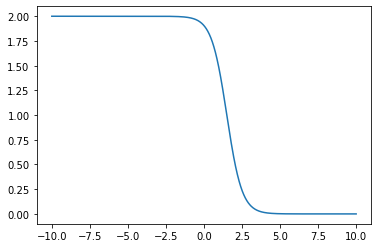

In [89]:
def penalty_func_test(x):
    return 1 * (- np.tanh((x - 1.5)) + 1)

x = np.linspace(-10, 10, 1000)
y = penalty_func_test(x)
plt.plot(x, y)
plt.show()
plt.close()

In [90]:
print(penalty_func_test(7.9))

5.521529900409661e-06


In [98]:
config = Config()
model = FourierModel(config).to(config.device)
model.train_model()

Output hidden; open in https://colab.research.google.com to view.

In [96]:
config = Config()
model = FourierModel(config).to(config.device)
model.train_model()

Output hidden; open in https://colab.research.google.com to view.

In [94]:
config = Config()
model = FourierModel(config).to(config.device)
model.train_model()

Output hidden; open in https://colab.research.google.com to view.

using cuda
iteration = 1000000
epoch_step = 100
test_step = 1000
model_name = Repressilator_Fourier
time_string = 20221121_195530
Ground truth has loss: Loss:0.00000107 Loss_1:0.00000000 Loss_2:0.00000107 Loss_3:0.00000000
Epoch [00100/1000000] Loss:1.327706 Loss_1:0.236596 Loss_2:1.091109 Loss_3:0.000000 Lr:0.009901 Time:1.414876s (0.02min in total, 235.79min remains)
Epoch [00200/1000000] Loss:0.900262 Loss_1:0.095285 Loss_2:0.804977 Loss_3:0.000000 Lr:0.009804 Time:1.413059s (0.05min in total, 235.61min remains)
Epoch [00300/1000000] Loss:0.870429 Loss_1:0.054701 Loss_2:0.815728 Loss_3:0.000000 Lr:0.009709 Time:1.372328s (0.07min in total, 233.28min remains)
Epoch [00400/1000000] Loss:0.868489 Loss_1:0.040551 Loss_2:0.827937 Loss_3:0.000000 Lr:0.009615 Time:1.393649s (0.09min in total, 232.99min remains)
Epoch [00500/1000000] Loss:0.861143 Loss_1:0.030386 Loss_2:0.830758 Loss_3:0.000000 Lr:0.009524 Time:1.382662s (0.12min in total, 232.44min remains)
Epoch [00600/1000000] Loss:0.864

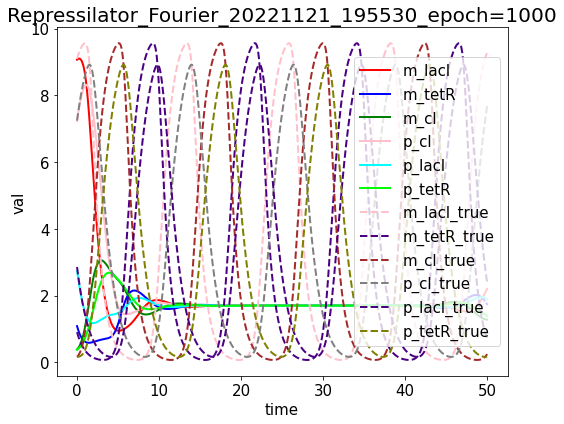

Figure is saved to /content/drive/My Drive/Workspace/Fourier_PINN//figure/Repressilator_Fourier_20221121_195530//Repressilator_Fourier_20221121_195530_epoch=1000.png


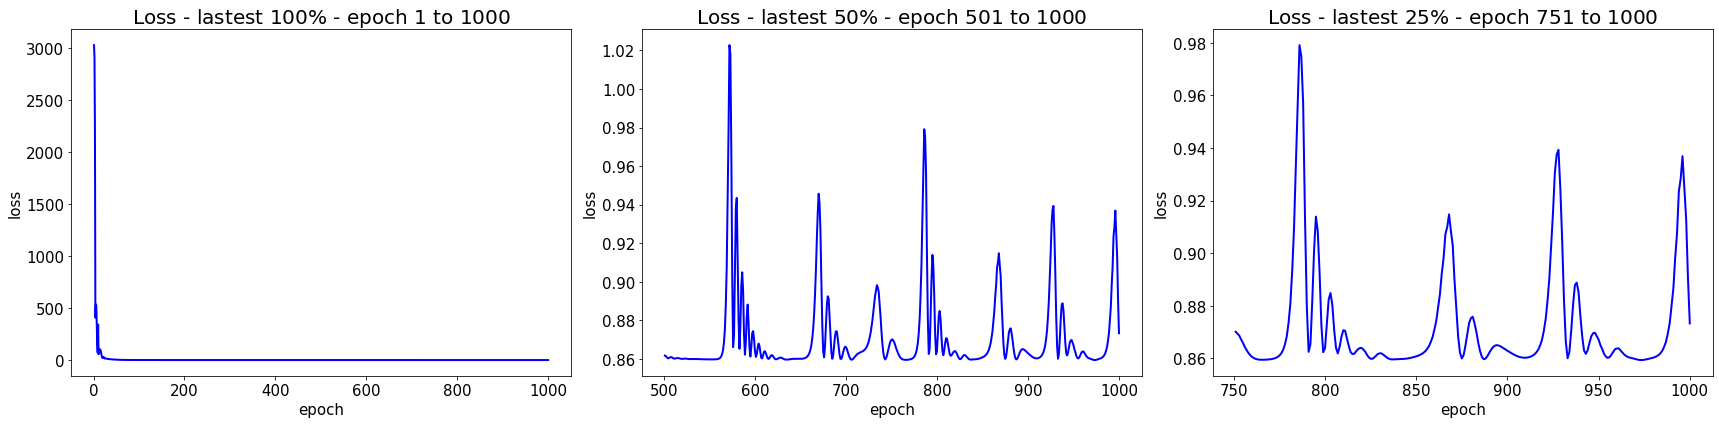

Epoch [01100/1000000] Loss:0.868949 Loss_1:0.027709 Loss_2:0.841240 Loss_3:0.000000 Lr:0.009009 Time:2.976927s (0.30min in total, 268.65min remains)


KeyboardInterrupt: ignored

In [21]:
config = Config()
model = FourierModel(config).to(config.device)
model.train_model()

In [17]:
config = Config()
model = FourierModel(config).to(config.device)
model.train_model()

Output hidden; open in https://colab.research.google.com to view.